# Iron Ore Indicator - Comprehensive P&L Analysis

**Strategy**: 7-Indicator Confirmation System with Market Regime Detection

**Date**: 2025-11-05

**Instrument**: DCE/i<00> (Iron Ore)

**Period**: 2024-10-25 to 2024-11-01 (Quick Test - 7 days)

**Purpose**: Quick test performance analysis with regime-aware trading simulation

---

## Strategy Overview

### Seven Technical Indicators:
1. **Triple EMA** (12/26/50) - Trend identification
2. **MACD** (12/26/9) - Momentum confirmation
3. **RSI** (14) - Mean reversion signals
4. **Bollinger Bands** (20, 2σ) - Price extremes
5. **ATR** (14) - Volatility measurement
6. **BB Width** - Volatility confirmation
7. **Volume EMA** (20) - Liquidity confirmation

### Four Market Regimes:
1. **Strong Uptrend** - Momentum long entries
2. **Strong Downtrend** - Momentum short entries
3. **Sideways/Ranging** - Mean reversion trades
4. **High Volatility Chaos** - No trading (capital preservation)

## 1. Setup and Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import svr3
from datetime import datetime

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Jupyter async support
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("✓ nest_asyncio enabled")
except ImportError:
    print("⚠️ Install nest-asyncio: pip install nest-asyncio")

# Load environment
from dotenv import load_dotenv
load_dotenv()

SVR_HOST = os.getenv("SVR_HOST")
SVR_TOKEN = os.getenv("SVR_TOKEN")

if not SVR_HOST or not SVR_TOKEN:
    print("❌ Error: SVR_HOST or SVR_TOKEN not found in .env file")
else:
    print(f"✓ Environment loaded: {SVR_HOST}")

✓ nest_asyncio enabled
✓ Environment loaded: 10.99.100.116


## 2. Data Fetching from SVR3 Server

In [2]:
async def fetch_indicator_data(start_date, end_date):
    """
    Fetch indicator data from svr3 server.
    
    Args:
        start_date: int format YYYYMMDDHHMMSS
        end_date: int format YYYYMMDDHHMMSS
    """
    print(f"📥 Fetching indicator data from {start_date} to {end_date}...")
    
    # Server configuration
    RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
    WS_URL = f"wss://{SVR_HOST}:4433/tm"
    TM_MASTER = (SVR_HOST, 6102)
    
    try:
        # Create reader
        reader = svr3.sv_reader(
            start_date,          # start
            end_date,            # end
            "IronOreIndicatorRelaxed",  # algoname (matches launch.json)
            900,                 # granularity
            "private",           # namespace
            "symbol",            # work_mode
            ["DCE"],             # markets
            ["i<00>"],           # codes
            False,               # persistent
            RAILS_URL,           # rails_url
            WS_URL,              # ws_url
            "",                  # user
            "",                  # hashed_password
            TM_MASTER            # tm_master
        )
        
        # Set token
        reader.token = SVR_TOKEN
        
        # Connection sequence
        print("   🔐 Logging in...")
        await reader.login()
        
        print("   🔌 Connecting...")
        await reader.connect()
        
        print("   🔄 Starting WebSocket loop...")
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        
        print("   🤝 Handshaking...")
        await reader.shakehand()
        
        print("   📊 Fetching data...")
        ret = await reader.save_by_symbol()
        
        # Extract data
        if ret and len(ret) > 1 and len(ret[1]) > 1:
            data = ret[1][1]
        else:
            print("   ⚠️ No data returned")
            return None
        
        if not data or len(data) == 0:
            print("   ⚠️ Empty data")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Parse timestamps
        if 'time_tag' in df.columns:
            try:
                import pycaitlynutils3 as pcu3
                df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
            except:
                df['timestamp'] = pd.to_datetime(df['time_tag'], unit='ms')
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

async def fetch_price_data(start_date, end_date):
    """
    Fetch price (OHLCV) data from svr3 server.
    """
    print(f"📥 Fetching price data from {start_date} to {end_date}...")
    
    RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
    WS_URL = f"wss://{SVR_HOST}:4433/tm"
    TM_MASTER = (SVR_HOST, 6102)
    
    try:
        reader = svr3.sv_reader(
            start_date,
            end_date,
            "SampleQuote",      # Fetch OHLCV data
            900,
            "global",            # Global namespace
            "symbol",
            ["DCE"],
            ["i<00>"],
            False,
            RAILS_URL,
            WS_URL,
            "",
            "",
            TM_MASTER
        )
        
        reader.token = SVR_TOKEN
        
        print("   🔐 Logging in...")
        await reader.login()
        await reader.connect()
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        await reader.shakehand()
        
        print("   📊 Fetching data...")
        ret = await reader.save_by_symbol()
        
        if ret and len(ret) > 1 and len(ret[1]) > 1:
            data = ret[1][1]
        else:
            print("   ⚠️ No data returned")
            return None
        
        if not data or len(data) == 0:
            print("   ⚠️ Empty data")
            return None
        
        df = pd.DataFrame(data)
        
        if 'time_tag' in df.columns:
            try:
                import pycaitlynutils3 as pcu3
                df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
            except:
                df['timestamp'] = pd.to_datetime(df['time_tag'], unit='ms')
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# QUICK TEST: Fetch data matching launch.json "IronOre - Quick Test (7 days)" configuration
# start_date = 20241025000000  # Oct 25, 2024
# end_date = 20241101000000    # Nov 1, 2024

# For full backtest (3 months), use:
start_date = 20250101000000  # Jan 1, 2025
end_date = 20250401235959    # Apr 1, 2025

print("="*70)
print("FETCHING DATA")
print("="*70)

# Fetch both indicator signals and price data
df_indicator = await fetch_indicator_data(start_date, end_date)
df_price = await fetch_price_data(start_date, end_date)

# Merge on timestamp
if df_indicator is not None and df_price is not None:
    df = pd.merge(df_indicator, df_price[['timestamp', 'open', 'high', 'low', 'close', 'volume']], 
                  on='timestamp', how='inner', suffixes=('', '_price'))
    
    print(f"\n✅ Data loaded successfully!")
    print(f"   Rows: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    display(df.head(10))
else:
    print("\n❌ Failed to load data")
    df = None

FETCHING DATA
📥 Fetching indicator data from 20250101000000 to 20250401235959...
   🔐 Logging in...
   🔌 Connecting...
   🔄 Starting WebSocket loop...
   🤝 Handshaking...
   📊 Fetching data...
   ✓ Fetched 1310 bars
📥 Fetching price data from 20250101000000 to 20250401235959...
   🔐 Logging in...
   📊 Fetching data...
   ✓ Fetched 1326 bars

✅ Data loaded successfully!
   Rows: 1310
   Columns: ['time_tag', 'granularity', 'code', 'market', 'struct_market', 'struct_code', 'namespace', '_preserved_field', 'bar_index', 'ema_12', 'ema_26', 'ema_50', 'macd', 'macd_signal', 'macd_histogram', 'rsi', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_width', 'bb_width_pct', 'atr', 'volume_ema', 'regime', 'signal', 'confidence', 'signal_strength', 'desired_contracts', 'contracts_to_add', 'position_state', 'cash', 'contracts_held', 'portfolio_value', 'timestamp', 'open', 'high', 'low', 'close', 'volume']
   Date range: 2025-01-02 01:30:00+00:00 to 2025-04-01 03:15:00+00:00


,time_tag,granularity,code,market,struct_market,struct_code,namespace,_preserved_field,bar_index,ema_12,...,position_state,cash,contracts_held,portfolio_value,timestamp,open,high,low,close,volume
0,1735781400000,900,i<00>,DCE,DCE,i<00>,1,1735781400000,1,780.000000,...,0,1000000.0,0,1000000.0,2025-01-02 01:30:00+00:00,779.5,782.5,778.0,780.0,21599
1,1735782300000,900,i<00>,DCE,DCE,i<00>,1,1735782300000,2,780.153846,...,0,1000000.0,0,1000000.0,2025-01-02 01:45:00+00:00,780.0,782.0,779.0,780.0,12261
2,1735783200000,900,i<00>,DCE,DCE,i<00>,1,1735783200000,3,780.745562,...,0,960800.0,50,1000000.0,2025-01-02 02:00:00+00:00,779.5,781.5,778.5,781.0,8464
3,1735784100000,900,i<00>,DCE,DCE,i<00>,1,1735784100000,4,781.169322,...,1,921625.0,100,999975.0,2025-01-02 02:15:00+00:00,781.0,784.0,780.0,784.0,22350
4,1735785900000,900,i<00>,DCE,DCE,i<00>,1,1735785900000,5,781.989426,...,1,882300.0,150,1000275.0,2025-01-02 02:45:00+00:00,783.0,784.5,782.0,783.5,12197
5,1735786800000,900,i<00>,DCE,DCE,i<00>,1,1735786800000,6,782.529514,...,1,843025.0,200,1000125.0,2025-01-02 03:00:00+00:00,783.5,786.5,783.5,786.5,20873
6,1735787700000,900,i<00>,DCE,DCE,i<00>,1,1735787700000,7,782.755743,...,1,803825.0,250,999825.0,2025-01-02 03:15:00+00:00,786.5,788.0,784.5,785.5,21999
7,1735788600000,900,i<00>,DCE,DCE,i<00>,1,1735788600000,8,782.331783,...,1,764825.0,300,998825.0,2025-01-02 03:30:00+00:00,785.5,786.5,783.5,784.0,8399
8,1735796700000,900,i<00>,DCE,DCE,i<00>,1,1735796700000,9,782.357662,...,1,725700.0,350,999575.0,2025-01-02 05:45:00+00:00,782.0,784.0,780.0,780.0,24996
9,1735797600000,900,i<00>,DCE,DCE,i<00>,1,1735797600000,10,781.994945,...,1,686700.0,400,998700.0,2025-01-02 06:00:00+00:00,780.0,783.0,779.5,782.5,14948


[2025-11-05 21:35:44][INFO]Connection lost
[2025-11-05 21:35:44][INFO]Connection lost


## 3. Extract Trades from Indicator Signals

**Important**: The indicator tracks portfolio value (PV) internally!

- Initial Capital: ¥1,000,000
- Position Size: 10 contracts per trade
- PV tracked in real-time: `portfolio_value`, `cash`, `contracts_held`

Signal interpretation:
- `signal = 1`: BUY (enter long when flat)
- `signal = -1`: SELL (exit long when in position)
- `signal = 0`: NEUTRAL (no action)

In [3]:
def extract_trades(df):
    """
    Extract round-trip trades from indicator position tracking.
    
    The indicator uses accumulation strategy:
    - Signal=1: ADD contracts (50 or 100 based on dip strength)
    - Signal=-1: CLOSE ALL positions
    
    A "trade" is from first BUY to final SELL (complete round-trip).
    
    Args:
        df: DataFrame with indicator signals and portfolio tracking
    
    Returns:
        DataFrame with completed round-trip trades
    """
    print("📊 Extracting round-trip trades from position tracking...")
    
    trades = []
    current_trade = None  # Track active round-trip trade
    
    for idx, row in df.iterrows():
        timestamp = row['timestamp']
        contracts = row['contracts_held']
        signal = row['signal']
        close = row['close']
        regime = row['regime']
        confidence = row['confidence']
        
        prev_contracts = df.iloc[idx-1]['contracts_held'] if idx > 0 else 0
        
        # Detect trade START (position opened from 0)
        if prev_contracts == 0 and contracts > 0:
            # New round-trip trade started
            current_trade = {
                'entry_time': timestamp,
                'entry_bar': idx,
                'first_entry_price': close,
                'max_contracts': contracts,
                'total_cost': contracts * close,  # Track total investment
                'regime': regime,
                'confidence': confidence
            }
        
        # Track position ACCUMULATION (adding to existing position)
        elif current_trade is not None and contracts > prev_contracts:
            # Adding to position - update weighted average entry
            added_contracts = contracts - prev_contracts
            added_cost = added_contracts * close
            current_trade['total_cost'] += added_cost
            current_trade['max_contracts'] = max(current_trade['max_contracts'], contracts)
        
        # Detect trade END (position closed to 0)
        elif prev_contracts > 0 and contracts == 0 and current_trade is not None:
            # Trade completed - position fully closed
            exit_price = close
            exit_value = prev_contracts * exit_price
            
            # Calculate average entry price
            avg_entry_price = current_trade['total_cost'] / current_trade['max_contracts']
            
            # Calculate P&L
            pnl = exit_value - current_trade['total_cost']
            
            trades.append({
                'entry_time': current_trade['entry_time'],
                'exit_time': timestamp,
                'entry_bar': current_trade['entry_bar'],
                'exit_bar': idx,
                'avg_entry_price': avg_entry_price,
                'exit_price': exit_price,
                'max_contracts': current_trade['max_contracts'],
                'total_cost': current_trade['total_cost'],
                'exit_value': exit_value,
                'regime': current_trade['regime'],
                'confidence': current_trade['confidence'],
                'pnl': pnl,
                'return_pct': (pnl / current_trade['total_cost'] * 100) if current_trade['total_cost'] > 0 else 0
            })
            
            # Reset for next trade
            current_trade = None
    
    # Handle any open position at end
    if current_trade is not None:
        final_contracts = df.iloc[-1]['contracts_held']
        final_price = df.iloc[-1]['close']
        unrealized_value = final_contracts * final_price
        unrealized_pnl = unrealized_value - current_trade['total_cost']
        
        print(f"   ⚠️ Open position at end:")
        print(f"      Contracts: {final_contracts}")
        print(f"      Avg Entry: ¥{current_trade['total_cost']/current_trade['max_contracts']:.2f}")
        print(f"      Current Price: ¥{final_price:.2f}")
        print(f"      Unrealized P&L: ¥{unrealized_pnl:,.2f}")
    
    trades_df = pd.DataFrame(trades)
    
    print(f"\n   Total round-trip trades: {len(trades_df)}")
    if len(trades_df) > 0:
        print(f"   Total P&L: ¥{trades_df['pnl'].sum():,.2f}")
        print(f"   Winning trades: {(trades_df['pnl'] > 0).sum()}")
        print(f"   Losing trades: {(trades_df['pnl'] < 0).sum()}")
        print(f"   Avg contracts per trade: {trades_df['max_contracts'].mean():.1f}")
    
    return trades_df

if df is not None:
    # Check if portfolio_value exists
    if 'portfolio_value' not in df.columns:
        print("⚠️ WARNING: portfolio_value not found in indicator data!")
        print("   Available columns:", list(df.columns))
        print("   Please run the indicator first to generate portfolio tracking data.")
    else:
        print(f"✅ Portfolio tracking data found!")
        print(f"   Initial PV: ¥{df['portfolio_value'].iloc[0]:,.2f}")
        print(f"   Final PV: ¥{df['portfolio_value'].iloc[-1]:,.2f}")
        print(f"   Total Return: {(df['portfolio_value'].iloc[-1]/df['portfolio_value'].iloc[0]-1)*100:.2f}%")
        
        # Show signal distribution
        signal_counts = df['signal'].value_counts().sort_index()
        print(f"\n📊 Signal Distribution:")
        print(f"   SELL (-1): {signal_counts.get(-1, 0)} bars")
        print(f"   NEUTRAL (0): {signal_counts.get(0, 0)} bars")
        print(f"   BUY (1): {signal_counts.get(1, 0)} bars")
        
        # Show position transitions
        position_changes = df[df['contracts_held'] != df['contracts_held'].shift(1)]
        print(f"\n📊 Position Changes: {len(position_changes)} transitions")
        
        # Show position state distribution
        if 'position_state' in df.columns:
            pos_counts = df['position_state'].value_counts().sort_index()
            print(f"\n📊 Position State Distribution:")
            print(f"   Flat (0): {pos_counts.get(0, 0)} bars")
            print(f"   In Position (1): {pos_counts.get(1, 0)} bars")
    
    # Extract trades
    trades_df = extract_trades(df)
    
    if len(trades_df) > 0:
        print("\n📈 Sample Trades:")
        display(trades_df.head(10))
    else:
        print("\n⚠️ No completed round-trip trades found in this period.")
        print("   This is normal for a 7-day quick test if positions are held.")
        print("   Portfolio value changes are still tracked correctly above.")
else:
    print("⚠️ No data available")

✅ Portfolio tracking data found!
   Initial PV: ¥1,000,000.00
   Final PV: ¥1,004,325.00
   Total Return: 0.43%

📊 Signal Distribution:
   SELL (-1): 7 bars
   NEUTRAL (0): 1250 bars
   BUY (1): 53 bars

📊 Position Changes: 61 transitions

📊 Position State Distribution:
   Flat (0): 24 bars
   In Position (1): 1286 bars
📊 Extracting round-trip trades from position tracking...
   ⚠️ Open position at end:
      Contracts: 900
      Avg Entry: ¥800.08
      Current Price: ¥784.00
      Unrealized P&L: ¥-14,475.00

   Total round-trip trades: 7
   Total P&L: ¥38,800.00
   Winning trades: 4
   Losing trades: 2
   Avg contracts per trade: 307.1

📈 Sample Trades:


,entry_time,exit_time,entry_bar,exit_bar,avg_entry_price,exit_price,max_contracts,total_cost,exit_value,regime,confidence,pnl,return_pct
0,2025-01-02 02:00:00+00:00,2025-01-02 14:15:00+00:00,2,18,781.733333,778.0,750,586300.0,583500.0,1,0.0,-2800.0,-0.477571
1,2025-01-02 14:30:00+00:00,2025-01-02 14:45:00+00:00,19,20,775.500000,776.5,100,77550.0,77650.0,2,0.6,100.0,0.128949
2,2025-01-02 15:00:00+00:00,2025-01-03 01:15:00+00:00,21,22,777.500000,771.0,100,77750.0,77100.0,2,0.6,-650.0,-0.836013
3,2025-01-03 01:30:00+00:00,2025-01-03 01:45:00+00:00,23,24,767.000000,769.5,100,76700.0,76950.0,2,0.6,250.0,0.325945
4,2025-01-03 02:00:00+00:00,2025-01-03 02:15:00+00:00,25,26,766.500000,767.0,100,76650.0,76700.0,2,0.6,50.0,0.065232
5,2025-01-03 03:00:00+00:00,2025-01-03 03:15:00+00:00,28,29,763.000000,763.0,100,76300.0,76300.0,2,0.6,0.0,0.000000
6,2025-01-03 03:30:00+00:00,2025-02-14 07:00:00+00:00,30,580,764.000000,810.5,900,687600.0,729450.0,2,0.6,41850.0,6.086387


## 4. Performance Metrics

In [4]:
def calculate_metrics(df, trades_df, initial_capital=1000000):
    """
    Calculate comprehensive performance metrics using portfolio_value from indicator.
    """
    # Use portfolio_value from indicator for equity calculations
    if 'portfolio_value' in df.columns:
        equity_series = df['portfolio_value'].dropna()
    else:
        print("⚠️ WARNING: portfolio_value not found!")
        return None
    
    # Calculate drawdown
    peak = equity_series.expanding().max()
    drawdown = (equity_series - peak) / peak
    max_drawdown = drawdown.min()
    
    final_equity = equity_series.iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital
    
    # Base metrics (always available)
    metrics = {
        'Total Bars': len(df),
        'Initial Capital (CNY)': initial_capital,
        'Final Equity (CNY)': final_equity,
        'Total Return (%)': total_return * 100,
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown * 100,
    }
    
    # Trade-specific metrics (only if trades exist)
    if len(trades_df) > 0:
        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] < 0]
        
        metrics.update({
            'Total Trades': len(trades_df),
            'Winning Trades': len(winning_trades),
            'Losing Trades': len(losing_trades),
            'Win Rate': len(winning_trades) / len(trades_df) if len(trades_df) > 0 else 0,
            'Total P&L (CNY)': trades_df['pnl'].sum(),
            'Avg Win (CNY)': winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0,
            'Avg Loss (CNY)': losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0,
            'Largest Win (CNY)': winning_trades['pnl'].max() if len(winning_trades) > 0 else 0,
            'Largest Loss (CNY)': losing_trades['pnl'].min() if len(losing_trades) > 0 else 0,
            'Profit Factor': (winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())) 
                            if len(losing_trades) > 0 and losing_trades['pnl'].sum() != 0 else np.inf,
            'Sharpe Ratio': (trades_df['return_pct'].mean() / trades_df['return_pct'].std() * np.sqrt(252)) 
                           if trades_df['return_pct'].std() > 0 else 0,
        })
    else:
        # No trades - calculate basic portfolio-level metrics
        daily_returns = equity_series.pct_change().dropna()
        
        metrics.update({
            'Total Trades': 0,
            'Note': 'No completed trades in this period (7-day test)',
            'Daily Sharpe (annualized)': (daily_returns.mean() / daily_returns.std() * np.sqrt(252)) 
                                         if daily_returns.std() > 0 and len(daily_returns) > 0 else 0,
        })
    
    return metrics

if df is not None and 'portfolio_value' in df.columns:
    metrics = calculate_metrics(df, trades_df)
    
    print("\n" + "="*70)
    print("PERFORMANCE METRICS")
    print("="*70)
    
    metrics_df = pd.DataFrame([metrics]).T
    metrics_df.columns = ['Value']
    
    # Format rows
    for idx in metrics_df.index:
        val = metrics_df.loc[idx, 'Value']
        if isinstance(val, str):
            continue  # Skip string values like 'Note'
        elif 'Rate' in idx or 'Drawdown (%)' in idx or 'Return (%)' in idx:
            metrics_df.loc[idx, 'Value'] = f"{val:.2%}"
        elif 'CNY' in idx:
            metrics_df.loc[idx, 'Value'] = f"¥{val:,.2f}"
        elif idx in ['Sharpe Ratio', 'Profit Factor', 'Daily Sharpe (annualized)']:
            metrics_df.loc[idx, 'Value'] = f"{val:.2f}"
        elif idx in ['Max Drawdown']:
            metrics_df.loc[idx, 'Value'] = f"{val:.4f}"
    
    display(metrics_df)
    print("="*70)
else:
    print("⚠️ Cannot calculate metrics (portfolio_value required)")
    metrics = None


PERFORMANCE METRICS


/tmp/ipykernel_162197/778903814.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '¥1,000,000.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_df.loc[idx, 'Value'] = f"¥{val:,.2f}"


,Value
Total Bars,1310.0
Initial Capital (CNY),"¥1,000,000.00"
Final Equity (CNY),"¥1,004,325.00"
Total Return (%),43.25%
Max Drawdown,-0.0710
Max Drawdown (%),-709.95%
Total Trades,7.0
Winning Trades,4.0
Losing Trades,2.0
Win Rate,57.14%


## 5. Regime Analysis

In [5]:
if df is not None:
    print("📊 Market Regime Distribution:")
    print("="*70)
    
    regime_names = {1: 'Strong Uptrend', 2: 'Strong Downtrend', 3: 'Sideways/Ranging', 4: 'High Volatility Chaos'}
    regime_counts = df['regime'].value_counts().sort_index()
    regime_pct = (regime_counts / len(df) * 100).round(2)
    
    regime_summary = pd.DataFrame({
        'Regime': [regime_names[i] for i in regime_counts.index],
        'Bars': regime_counts.values,
        'Percentage': [f"{p}%" for p in regime_pct.values]
    })
    
    display(regime_summary)
    
    # Regime-specific trade performance
    if len(trades_df) > 0:
        print("\n📊 Trade Performance by Regime:")
        print("="*70)
        
        regime_performance = trades_df.groupby('regime').agg({
            'pnl': ['count', 'sum', 'mean'],
            'return_pct': 'mean',
            'confidence': 'mean'
        }).round(2)
        
        regime_performance.index = regime_performance.index.map(regime_names)
        display(regime_performance)

📊 Market Regime Distribution:


,Regime,Bars,Percentage
0,Strong Uptrend,7,0.53%
1,Strong Downtrend,13,0.99%
2,Sideways/Ranging,11,0.84%
3,High Volatility Chaos,1279,97.63%



📊 Trade Performance by Regime:


pnl                   return_pct confidence
                 count      sum     mean       mean       mean
regime                                                        
Strong Uptrend       1  -2800.0 -2800.00      -0.48        0.0
Strong Downtrend     6  41600.0  6933.33       0.96        0.6

## 6. Comprehensive Visualizations


📊 Portfolio Value Statistics:
   Initial PV: ¥1,000,000.00
   Final PV: ¥1,004,325.00
   Max PV: ¥1,053,950.00 (at 2025-02-20 15:00:00+00:00)
   Min PV: ¥976,025.00 (at 2025-01-09 01:45:00+00:00)
   Total Return: 0.43%
   Peak to Final Drop: ¥49,625.00 (-4.71%)

✅ Comprehensive visualization saved as 'analysis_comprehensive.png'


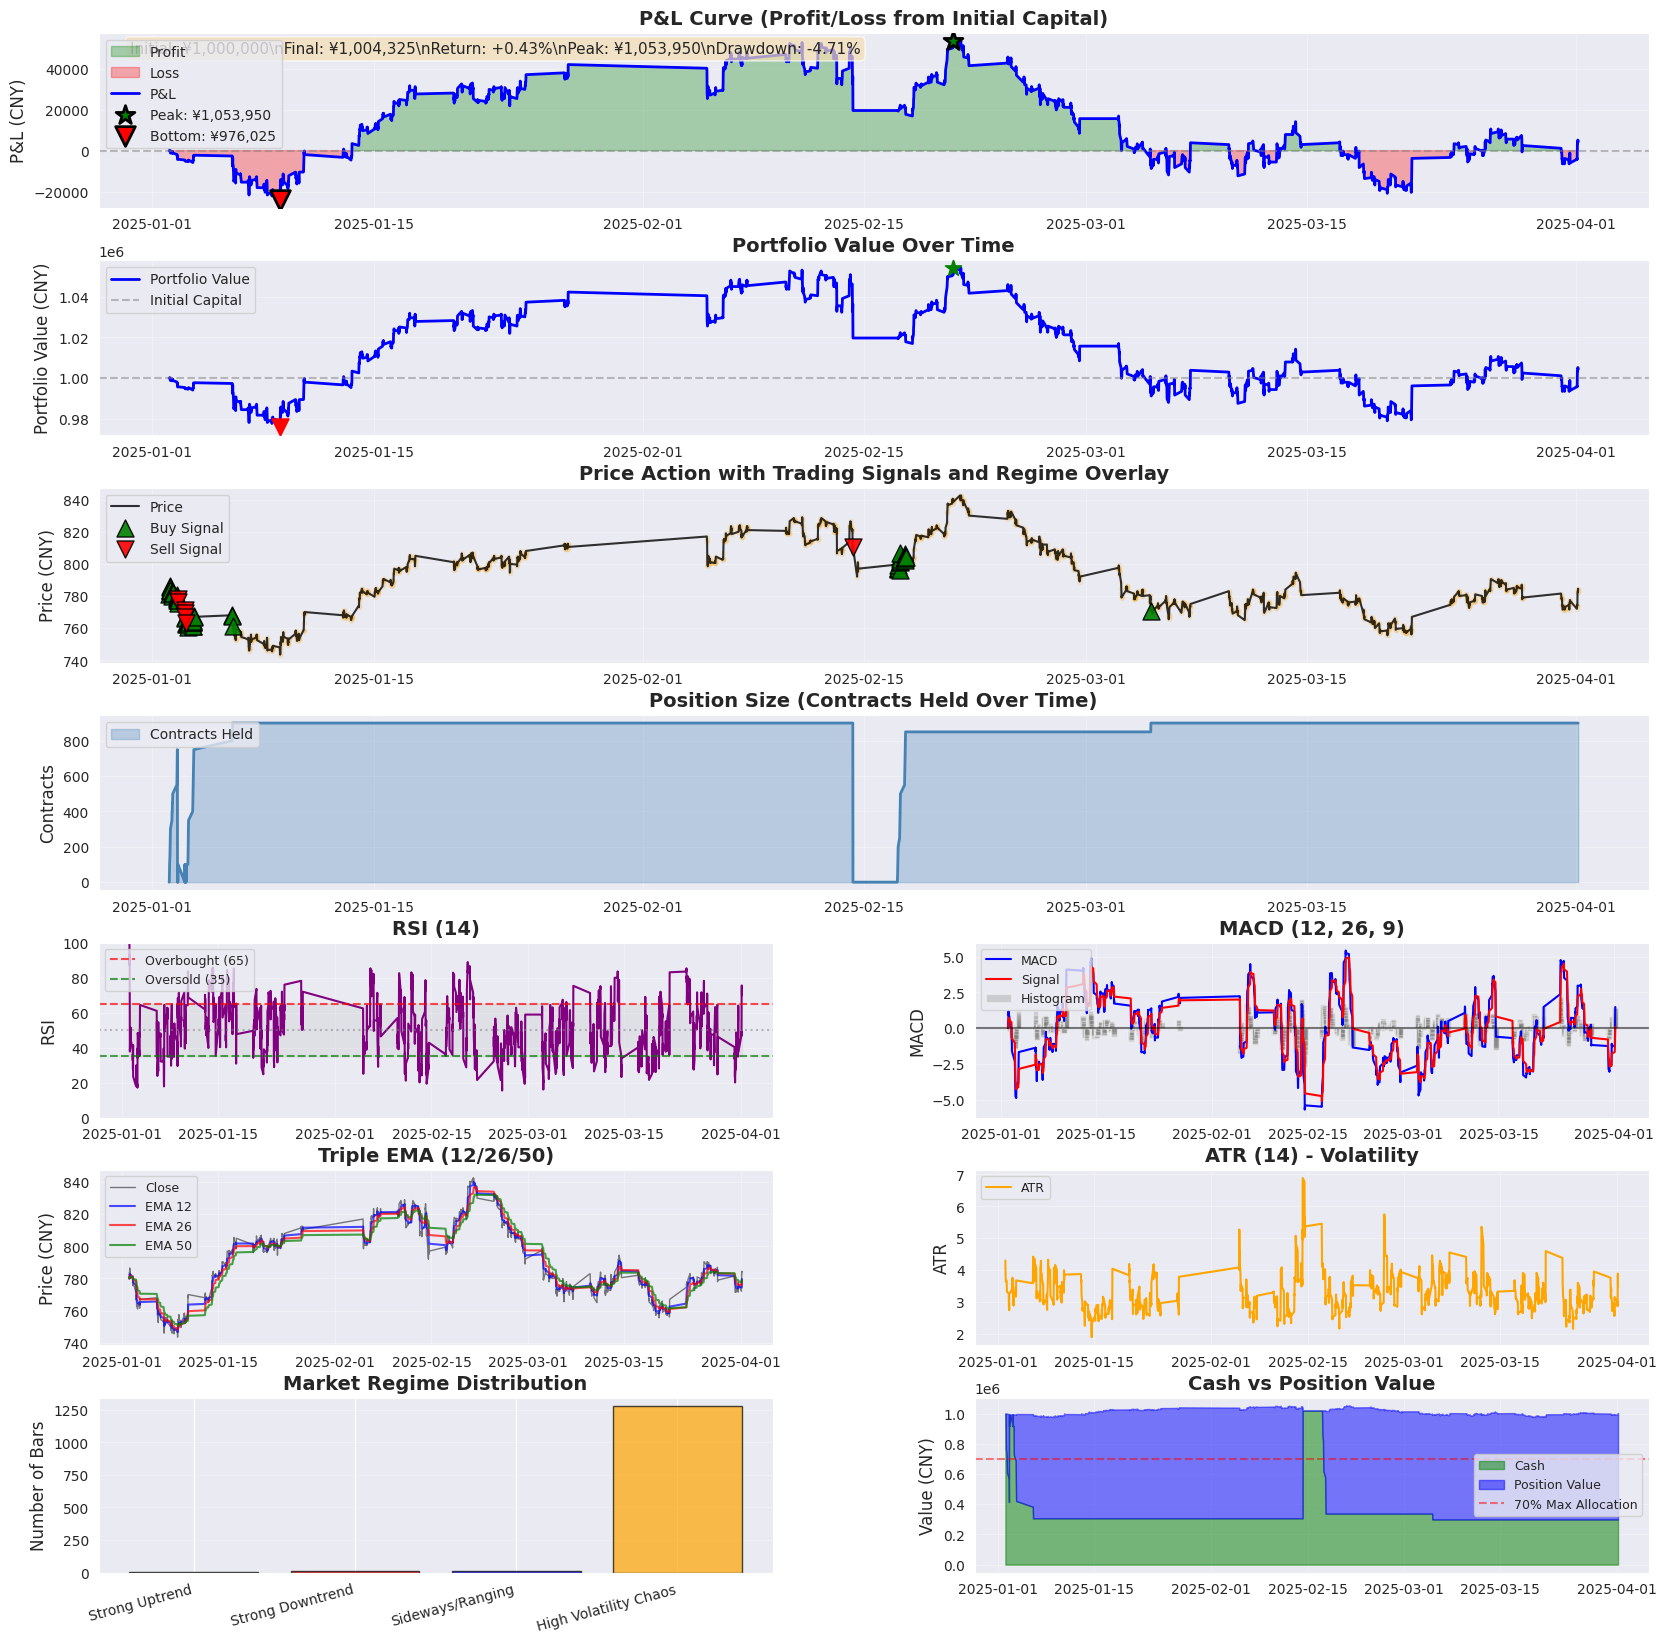

In [6]:
if df is not None and 'portfolio_value' in df.columns:
    # Calculate P&L and statistics
    initial_pv = df['portfolio_value'].iloc[0]
    final_pv = df['portfolio_value'].iloc[-1]
    max_pv = df['portfolio_value'].max()
    min_pv = df['portfolio_value'].min()
    pv_return = (final_pv/initial_pv-1)*100
    
    # Find where max/min occurred
    max_idx = df['portfolio_value'].idxmax()
    min_idx = df['portfolio_value'].idxmin()
    max_time = df.loc[max_idx, 'timestamp']
    min_time = df.loc[min_idx, 'timestamp']
    
    # Calculate P&L curve (profit/loss from initial capital)
    df['pnl'] = df['portfolio_value'] - initial_pv
    df['pnl_pct'] = (df['portfolio_value'] / initial_pv - 1) * 100
    
    print(f"\n📊 Portfolio Value Statistics:")
    print(f"   Initial PV: ¥{initial_pv:,.2f}")
    print(f"   Final PV: ¥{final_pv:,.2f}")
    print(f"   Max PV: ¥{max_pv:,.2f} (at {max_time})")
    print(f"   Min PV: ¥{min_pv:,.2f} (at {min_time})")
    print(f"   Total Return: {pv_return:.2f}%")
    print(f"   Peak to Final Drop: ¥{max_pv - final_pv:,.2f} ({(final_pv/max_pv-1)*100:.2f}%)")
    
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(7, 2, hspace=0.3, wspace=0.3)
    
    regime_colors = {1: 'green', 2: 'red', 3: 'blue', 4: 'orange'}
    
    # Panel 1: P&L Curve (ABSOLUTE PROFIT/LOSS)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.fill_between(df['timestamp'], 0, df['pnl'], 
                     where=df['pnl']>=0, alpha=0.3, color='green', label='Profit')
    ax1.fill_between(df['timestamp'], 0, df['pnl'], 
                     where=df['pnl']<0, alpha=0.3, color='red', label='Loss')
    ax1.plot(df['timestamp'], df['pnl'], linewidth=2, color='blue', label='P&L')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Mark max and min points
    ax1.scatter([max_time], [df.loc[max_idx, 'pnl']], 
               color='green', s=200, marker='*', zorder=5, 
               label=f'Peak: ¥{max_pv:,.0f}', edgecolors='black', linewidths=2)
    ax1.scatter([min_time], [df.loc[min_idx, 'pnl']], 
               color='red', s=200, marker='v', zorder=5,
               label=f'Bottom: ¥{min_pv:,.0f}', edgecolors='black', linewidths=2)
    
    ax1.set_title('P&L Curve (Profit/Loss from Initial Capital)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('P&L (CNY)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Add text box with summary
    textstr = f'Initial: ¥{initial_pv:,.0f}\\nFinal: ¥{final_pv:,.0f}\\nReturn: {pv_return:+.2f}%\\nPeak: ¥{max_pv:,.0f}\\nDrawdown: {(final_pv/max_pv-1)*100:.2f}%'
    ax1.text(0.02, 0.95, textstr, transform=ax1.transAxes, fontsize=11, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Panel 2: Portfolio Value Curve
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(df['timestamp'], df['portfolio_value'], linewidth=2, color='blue', label='Portfolio Value')
    ax2.axhline(y=initial_pv, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    ax2.scatter([max_time], [max_pv], color='green', s=150, marker='*', zorder=5)
    ax2.scatter([min_time], [min_pv], color='red', s=150, marker='v', zorder=5)
    ax2.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Portfolio Value (CNY)', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Price with Signals and Contracts Held
    ax3 = fig.add_subplot(gs[2, :])
    
    # Color background by regime
    for regime_id, color in regime_colors.items():
        regime_df = df[df['regime'] == regime_id]
        if len(regime_df) > 0:
            ax3.scatter(regime_df['timestamp'], regime_df['close'], 
                       c=color, alpha=0.1, s=10)
    
    ax3.plot(df['timestamp'], df['close'], alpha=0.8, color='black', label='Price', linewidth=1.5)
    
    # Plot BUY signals (signal=1)
    buy_signals = df[df['signal'] == 1]
    if len(buy_signals) > 0:
        ax3.scatter(buy_signals['timestamp'], buy_signals['close'],
                   color='green', marker='^', s=150, label='Buy Signal', alpha=0.9, zorder=5, edgecolors='black')
    
    # Plot SELL signals (signal=-1)
    sell_signals = df[df['signal'] == -1]
    if len(sell_signals) > 0:
        ax3.scatter(sell_signals['timestamp'], sell_signals['close'],
                   color='red', marker='v', s=150, label='Sell Signal', alpha=0.9, zorder=5, edgecolors='black')
    
    ax3.set_title('Price Action with Trading Signals and Regime Overlay', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Price (CNY)', fontsize=12)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Contracts Held Over Time
    ax4 = fig.add_subplot(gs[3, :])
    ax4.fill_between(df['timestamp'], 0, df['contracts_held'], alpha=0.3, color='steelblue', label='Contracts Held')
    ax4.plot(df['timestamp'], df['contracts_held'], color='steelblue', linewidth=2)
    ax4.set_title('Position Size (Contracts Held Over Time)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Contracts', fontsize=12)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # Panel 5: RSI
    ax5 = fig.add_subplot(gs[4, 0])
    ax5.plot(df['timestamp'], df['rsi'], color='purple', linewidth=1.5)
    ax5.axhline(y=65, color='red', linestyle='--', alpha=0.7, label='Overbought (65)')
    ax5.axhline(y=35, color='green', linestyle='--', alpha=0.7, label='Oversold (35)')
    ax5.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    ax5.fill_between(df['timestamp'], 35, 65, alpha=0.1, color='gray')
    ax5.set_title('RSI (14)', fontsize=14, fontweight='bold')
    ax5.set_ylabel('RSI', fontsize=12)
    ax5.set_ylim(0, 100)
    ax5.legend(loc='upper left', fontsize=9)
    ax5.grid(True, alpha=0.3)
    
    # Panel 6: MACD
    ax6 = fig.add_subplot(gs[4, 1])
    ax6.plot(df['timestamp'], df['macd'], color='blue', linewidth=1.5, label='MACD')
    ax6.plot(df['timestamp'], df['macd_signal'], color='red', linewidth=1.5, label='Signal')
    ax6.bar(df['timestamp'], df['macd_histogram'], alpha=0.3, color='gray', label='Histogram')
    ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax6.set_title('MACD (12, 26, 9)', fontsize=14, fontweight='bold')
    ax6.set_ylabel('MACD', fontsize=12)
    ax6.legend(loc='upper left', fontsize=9)
    ax6.grid(True, alpha=0.3)
    
    # Panel 7: Triple EMA
    ax7 = fig.add_subplot(gs[5, 0])
    ax7.plot(df['timestamp'], df['close'], alpha=0.5, color='black', label='Close', linewidth=1)
    ax7.plot(df['timestamp'], df['ema_12'], alpha=0.7, color='blue', label='EMA 12', linewidth=1.5)
    ax7.plot(df['timestamp'], df['ema_26'], alpha=0.7, color='red', label='EMA 26', linewidth=1.5)
    ax7.plot(df['timestamp'], df['ema_50'], alpha=0.7, color='green', label='EMA 50', linewidth=1.5)
    ax7.set_title('Triple EMA (12/26/50)', fontsize=14, fontweight='bold')
    ax7.set_ylabel('Price (CNY)', fontsize=12)
    ax7.legend(loc='upper left', fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # Panel 8: ATR (Volatility)
    ax8 = fig.add_subplot(gs[5, 1])
    ax8.plot(df['timestamp'], df['atr'], color='orange', linewidth=1.5, label='ATR')
    ax8.set_title('ATR (14) - Volatility', fontsize=14, fontweight='bold')
    ax8.set_ylabel('ATR', fontsize=12)
    ax8.legend(loc='upper left', fontsize=9)
    ax8.grid(True, alpha=0.3)
    
    # Panel 9: Regime Distribution
    ax9 = fig.add_subplot(gs[6, 0])
    regime_names = {1: 'Strong Uptrend', 2: 'Strong Downtrend', 3: 'Sideways/Ranging', 4: 'High Volatility Chaos'}
    regime_counts = df['regime'].value_counts().sort_index()
    regime_labels = [regime_names[i] for i in regime_counts.index]
    colors = [regime_colors[i] for i in regime_counts.index]
    ax9.bar(regime_labels, regime_counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax9.set_title('Market Regime Distribution', fontsize=14, fontweight='bold')
    ax9.set_ylabel('Number of Bars', fontsize=12)
    ax9.grid(True, alpha=0.3, axis='y')
    plt.setp(ax9.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # Panel 10: Cash vs Position Value
    ax10 = fig.add_subplot(gs[6, 1])
    position_value = df['contracts_held'] * df['close']
    ax10.fill_between(df['timestamp'], 0, df['cash'], alpha=0.5, color='green', label='Cash')
    ax10.fill_between(df['timestamp'], df['cash'], df['portfolio_value'], alpha=0.5, color='blue', label='Position Value')
    ax10.axhline(y=initial_pv * 0.70, color='red', linestyle='--', alpha=0.5, label='70% Max Allocation')
    ax10.set_title('Cash vs Position Value', fontsize=14, fontweight='bold')
    ax10.set_ylabel('Value (CNY)', fontsize=12)
    ax10.legend(fontsize=9)
    ax10.grid(True, alpha=0.3)
    
    plt.savefig('analysis_comprehensive.png', dpi=150, bbox_inches='tight')
    print("\n✅ Comprehensive visualization saved as 'analysis_comprehensive.png'")
    plt.show()
else:
    print("⚠️ No data available for visualization (portfolio_value field required)")

## 7. Signal Confidence Analysis

📊 Signal Confidence Analysis:


/tmp/ipykernel_162197/1372557602.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_analysis = trades_df.groupby(confidence_bins).agg({


pnl                   return_pct
                 count      sum     mean       mean
confidence                                         
Low (0-0.3)          0      0.0      NaN        NaN
Medium (0.3-0.6)     6  41600.0  6933.33       0.96
High (0.6-1.0)       0      0.0      NaN        NaN

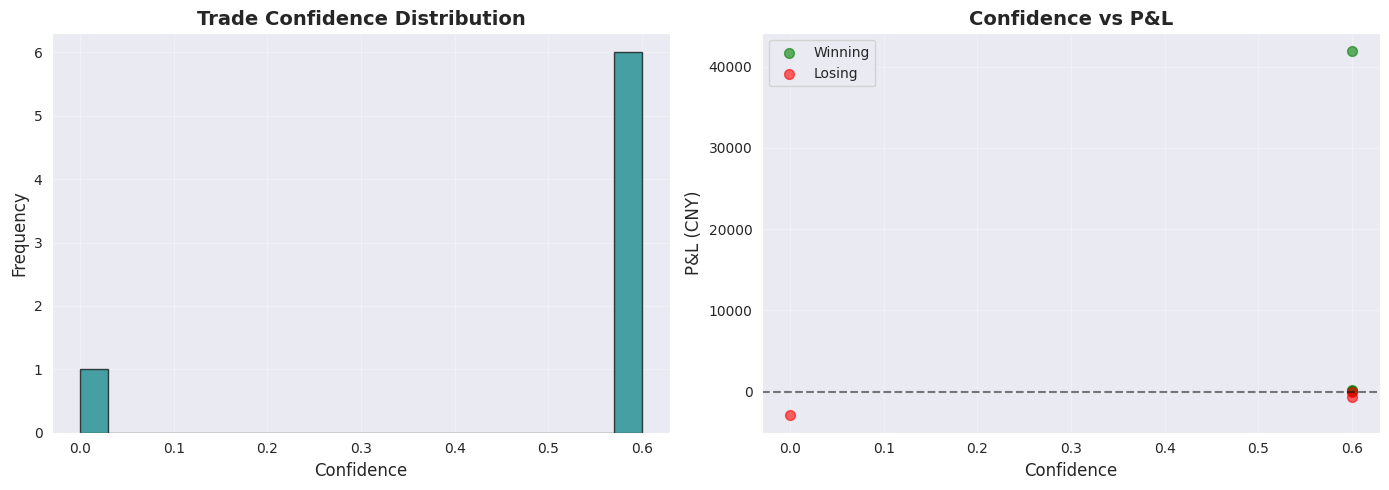

In [7]:
if df is not None and len(trades_df) > 0:
    print("📊 Signal Confidence Analysis:")
    print("="*70)
    
    # Analyze confidence vs P&L
    confidence_bins = pd.cut(trades_df['confidence'], bins=[0, 0.3, 0.6, 1.0], 
                            labels=['Low (0-0.3)', 'Medium (0.3-0.6)', 'High (0.6-1.0)'])
    
    confidence_analysis = trades_df.groupby(confidence_bins).agg({
        'pnl': ['count', 'sum', 'mean'],
        'return_pct': 'mean'
    }).round(2)
    
    display(confidence_analysis)
    
    # Visualize confidence vs outcome
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confidence distribution
    axes[0].hist(trades_df['confidence'], bins=20, edgecolor='black', alpha=0.7, color='teal')
    axes[0].set_title('Trade Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Confidence', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Confidence vs P&L scatter
    winning = trades_df[trades_df['pnl'] > 0]
    losing = trades_df[trades_df['pnl'] <= 0]
    
    axes[1].scatter(winning['confidence'], winning['pnl'], 
                   color='green', alpha=0.6, s=50, label='Winning')
    axes[1].scatter(losing['confidence'], losing['pnl'], 
                   color='red', alpha=0.6, s=50, label='Losing')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_title('Confidence vs P&L', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Confidence', fontsize=12)
    axes[1].set_ylabel('P&L (CNY)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Monthly Performance Breakdown

📅 Monthly Performance:


/tmp/ipykernel_162197/603016750.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  trades_df['month'] = pd.to_datetime(trades_df['exit_time']).dt.to_period('M')


pnl                 return_pct
             sum count      mean       mean
month                                      
2025-01  -3050.0     6   -508.33      -0.13
2025-02  41850.0     1  41850.00       6.09

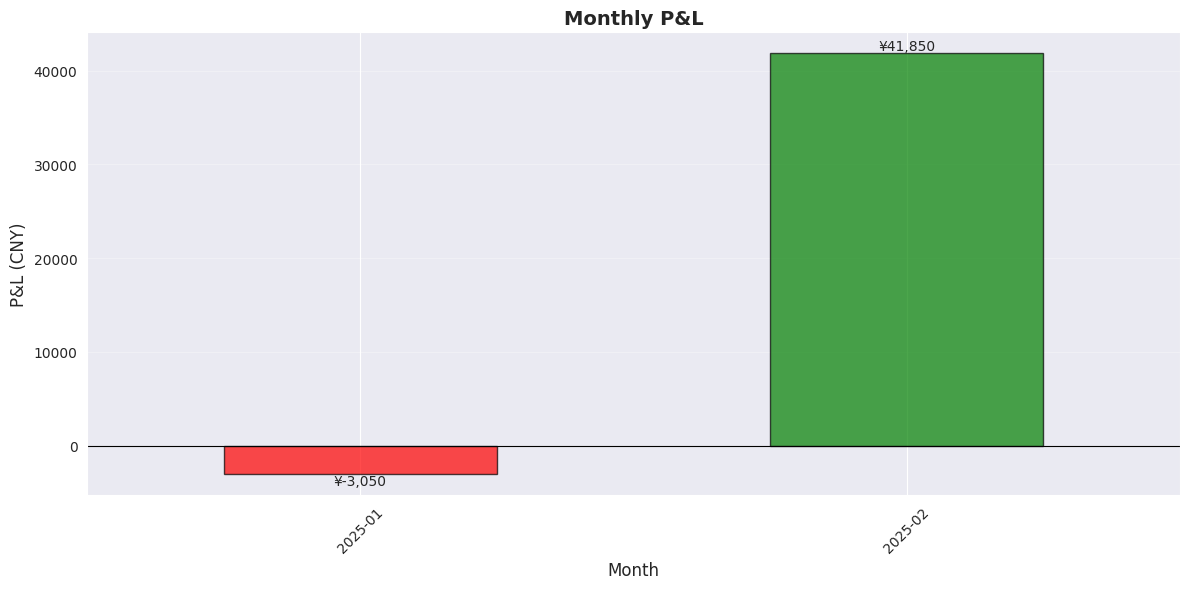

In [8]:
if df is not None and len(trades_df) > 0:
    print("📅 Monthly Performance:")
    print("="*70)
    
    # Add month column to trades
    trades_df['month'] = pd.to_datetime(trades_df['exit_time']).dt.to_period('M')
    
    monthly_pnl = trades_df.groupby('month').agg({
        'pnl': ['sum', 'count', 'mean'],
        'return_pct': 'mean'
    }).round(2)
    
    display(monthly_pnl)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    monthly_totals = trades_df.groupby('month')['pnl'].sum()
    colors = ['green' if x > 0 else 'red' for x in monthly_totals]
    monthly_totals.plot(kind='bar', ax=ax, color=colors, edgecolor='black', alpha=0.7)
    ax.set_title('Monthly P&L', fontsize=14, fontweight='bold')
    ax.set_ylabel('P&L (CNY)', fontsize=12)
    ax.set_xlabel('Month', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, v in enumerate(monthly_totals):
        ax.text(i, v, f'¥{v:,.0f}', ha='center', 
               va='bottom' if v > 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## 9. Summary and Evaluation

In [9]:
if metrics and df is not None:
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    
    print(f"Period: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
    print(f"Total Bars: {metrics['Total Bars']}")
    
    # Portfolio metrics (always available)
    print(f"Initial Capital: ¥{metrics['Initial Capital (CNY)']:,.2f}")
    print(f"Final Portfolio Value: ¥{metrics['Final Equity (CNY)']:,.2f}")
    print(f"Total Return: {metrics['Total Return (%)']:.2f}%")
    print(f"Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%")
    
    # Trade metrics (if available)
    if 'Total Trades' in metrics and metrics['Total Trades'] > 0:
        print(f"\nTrade Statistics:")
        print(f"Total Trades: {metrics['Total Trades']}")
        print(f"Total P&L: ¥{metrics['Total P&L (CNY)']:,.2f}")
        print(f"Win Rate: {metrics['Win Rate']:.2%}")
        print(f"Profit Factor: {metrics['Profit Factor']:.2f}")
        print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    else:
        print(f"\nNo completed round-trip trades in this period (normal for 7-day test)")
        if 'Daily Sharpe (annualized)' in metrics:
            print(f"Daily Sharpe Ratio (annualized): {metrics['Daily Sharpe (annualized)']:.2f}")
    
    print("\n" + "="*70)
    print("EVALUATION")
    print("="*70)
    
    # Evaluation criteria (adapted for short test period)
    if 'Total Trades' in metrics and metrics['Total Trades'] > 0:
        # Full evaluation with trades
        criteria = [
            ("✅" if metrics['Sharpe Ratio'] > 1.0 else "❌", 
             f"Sharpe Ratio > 1.0: {metrics['Sharpe Ratio']:.2f}"),
            ("✅" if metrics['Win Rate'] > 0.5 else "❌", 
             f"Win Rate > 50%: {metrics['Win Rate']:.2%}"),
            ("✅" if metrics['Profit Factor'] > 1.5 else "❌", 
             f"Profit Factor > 1.5: {metrics['Profit Factor']:.2f}"),
            ("✅" if abs(metrics['Max Drawdown (%)']) < 20 else "❌", 
             f"Max Drawdown < 20%: {abs(metrics['Max Drawdown (%)']):.2f}%"),
            ("✅" if metrics['Total P&L (CNY)'] > 0 else "❌", 
             f"Total P&L > 0: ¥{metrics['Total P&L (CNY)']:,.2f}"),
            ("✅" if metrics['Total Return (%)'] > 0 else "⚠️", 
             f"Total Return > 0%: {metrics['Total Return (%)']:.2f}%")
        ]
    else:
        # Portfolio-level evaluation only
        criteria = [
            ("✅" if metrics['Total Return (%)'] > 0 else "⚠️", 
             f"Total Return > 0%: {metrics['Total Return (%)']:.2f}%"),
            ("✅" if abs(metrics['Max Drawdown (%)']) < 5 else "⚠️", 
             f"Max Drawdown < 5%: {abs(metrics['Max Drawdown (%)']):.2f}%"),
            ("ℹ️", 
             f"Period too short for full evaluation (7-day quick test)"),
        ]
    
    for status, criterion in criteria:
        print(f"{status} {criterion}")
    
    # Count passes (exclude info items)
    passed = sum(1 for status, _ in criteria if status == "✅")
    total = sum(1 for status, _ in criteria if status in ["✅", "❌", "⚠️"])
    
    if total > 0:
        print(f"\n📊 Passed: {passed}/{total} criteria")
    
    # Conclusion
    if 'Total Trades' in metrics and metrics['Total Trades'] > 0:
        if passed >= total * 0.8:
            print("\n🎉 Strategy shows strong performance! Consider running full backtest.")
        elif passed >= total * 0.5:
            print("\n⚠️ Strategy shows potential but needs optimization.")
        else:
            print("\n❌ Strategy needs significant improvement before production.")
    else:
        if metrics['Total Return (%)'] > 0 and abs(metrics['Max Drawdown (%)']) < 5:
            print("\n✅ Quick test shows positive results. Run full backtest for complete evaluation.")
        else:
            print("\n⚠️ Quick test complete. Run full backtest (3+ months) for comprehensive analysis.")
    
    print("="*70)
else:
    print("\n❌ No metrics available for evaluation")


SUMMARY
Period: 2025-01-02 to 2025-04-01
Total Bars: 1310
Initial Capital: ¥1,000,000.00
Final Portfolio Value: ¥1,004,325.00
Total Return: 0.43%
Max Drawdown: -7.10%

Trade Statistics:
Total Trades: 7
Total P&L: ¥38,800.00
Win Rate: 57.14%
Profit Factor: 12.25
Sharpe Ratio: 5.04

EVALUATION
✅ Sharpe Ratio > 1.0: 5.04
✅ Win Rate > 50%: 57.14%
✅ Profit Factor > 1.5: 12.25
✅ Max Drawdown < 20%: 7.10%
✅ Total P&L > 0: ¥38,800.00
✅ Total Return > 0%: 0.43%

📊 Passed: 6/6 criteria

🎉 Strategy shows strong performance! Consider running full backtest.


## 10. Export Results

In [10]:
if df is not None and 'portfolio_value' in df.columns:
    # Export portfolio tracking data (always available)
    portfolio_export = df[['timestamp', 'portfolio_value', 'cash', 'contracts_held', 
                          'regime', 'signal', 'confidence', 'close', 'volume']].copy()
    portfolio_export.to_csv('portfolio_tracking.csv', index=False)
    print("✅ Portfolio tracking data exported to 'portfolio_tracking.csv'")
    
    # Export trades to CSV (if any)
    if len(trades_df) > 0:
        trades_df.to_csv('trades_analysis.csv', index=False)
        print("✅ Trades exported to 'trades_analysis.csv'")
    else:
        print("⚠️ No completed trades to export (normal for 7-day quick test)")
    
    # Export metrics
    if metrics:
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv('performance_metrics.csv', index=False)
        print("✅ Metrics exported to 'performance_metrics.csv'")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    print(f"\n📊 Final Results:")
    print(f"   Period: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
    print(f"   Total Bars: {len(df)}")
    print(f"   Initial Capital: ¥1,000,000")
    print(f"   Final PV: ¥{df['portfolio_value'].iloc[-1]:,.2f}")
    print(f"   Total Return: {(df['portfolio_value'].iloc[-1]/df['portfolio_value'].iloc[0]-1)*100:.2f}%")
    
    if len(trades_df) > 0:
        print(f"   Completed Trades: {len(trades_df)}")
        print(f"   Win Rate: {(trades_df['pnl']>0).sum()/len(trades_df)*100:.1f}%")
    else:
        print(f"   Completed Trades: 0 (position may still be open)")
    
    # Check for open position
    if df['contracts_held'].iloc[-1] > 0:
        print(f"\n⚠️ Open Position:")
        print(f"   Contracts: {df['contracts_held'].iloc[-1]}")
        print(f"   Current Price: ¥{df['close'].iloc[-1]:.2f}")
        print(f"   Position Value: ¥{df['contracts_held'].iloc[-1] * df['close'].iloc[-1]:,.2f}")
    
    print("\n📈 Next Steps:")
    if len(trades_df) == 0:
        print("   1. Run full backtest (3+ months) for complete trade analysis")
        print("   2. Adjust date range in cell 4 to: start=20250101000000, end=20250401235959")
    else:
        print("   1. Review trade performance and metrics")
        print("   2. Optimize parameters if needed")
        print("   3. Run replay consistency test")
    
    print("="*70)
else:
    print("⚠️ No data to export (portfolio_value field required)")

✅ Portfolio tracking data exported to 'portfolio_tracking.csv'
✅ Trades exported to 'trades_analysis.csv'
✅ Metrics exported to 'performance_metrics.csv'

ANALYSIS COMPLETE

📊 Final Results:
   Period: 2025-01-02 to 2025-04-01
   Total Bars: 1310
   Initial Capital: ¥1,000,000
   Final PV: ¥1,004,325.00
   Total Return: 0.43%
   Completed Trades: 7
   Win Rate: 57.1%

⚠️ Open Position:
   Contracts: 900
   Current Price: ¥784.00
   Position Value: ¥705,600.00

📈 Next Steps:
   1. Review trade performance and metrics
   2. Optimize parameters if needed
   3. Run replay consistency test
